In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [28]:
from data.synthetic_generator import synthetic3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

fmri_dataset = 'data/dataset/dataset_all_subjects_LEiDA.hdf5'

def get_param(model, show=True):
    para = model.get_mixture_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

### Generetate Synthetic 3D dataset

In [17]:
sig1 = torch.diag(torch.tensor([1, 1e-3, 1e-3]))
sig2 = torch.eye(3) + 0.9 * (torch.ones(3) - torch.eye(3))
sig3 = torch.diag(torch.tensor([1e-3, 1, 1])) \
       + 0.9 * torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

SIGMAs = torch.stack([sig1, sig2, sig3], dim=0)
print(SIGMAs, '\n-----------')

PI = [0.6, 0.2, 0.2]

X, cluster_id = synthetic3D(pi=PI, Sigmas=SIGMAs, num_points=3000, as_array=False)

tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 0.0010, 0.0000],
         [0.0000, 0.0000, 0.0010]],

        [[1.0000, 0.9000, 0.9000],
         [0.9000, 1.0000, 0.9000],
         [0.9000, 0.9000, 1.0000]],

        [[0.0010, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.9000],
         [0.0000, 0.9000, 1.0000]]]) 
-----------
Simulate 3000 point from 3 of clusters


### Train on synthecic data

<IPython.core.display.Javascript object>


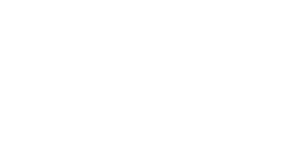

pi
tensor([0.3030, 0.3964, 0.3005])
------------------------------
mix_comp_0
{'mu': tensor([0.6861, 0.2975, 0.6639]), 'kappa': tensor([0.0381])}
------------------------------
mix_comp_1
{'mu': tensor([0.0275, 0.8554, 0.5172]), 'kappa': tensor([0.1619])}
------------------------------
mix_comp_2
{'mu': tensor([0.6328, 0.7358, 0.2411]), 'kappa': tensor([0.5794])}
------------------------------


100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 331.64it/s]

pi
tensor([0.0126, 0.2522, 0.7351])
------------------------------
mix_comp_0
{'mu': tensor([0.2492, 0.6730, 0.6964]), 'kappa': tensor([2.9646])}
------------------------------
mix_comp_1
{'mu': tensor([0.2092, 0.6782, 0.7045]), 'kappa': tensor([4.0145])}
------------------------------
mix_comp_2
{'mu': tensor([0.9996, 0.0203, 0.0200]), 'kappa': tensor([5.5421])}
------------------------------


<IPython.core.display.Javascript object>


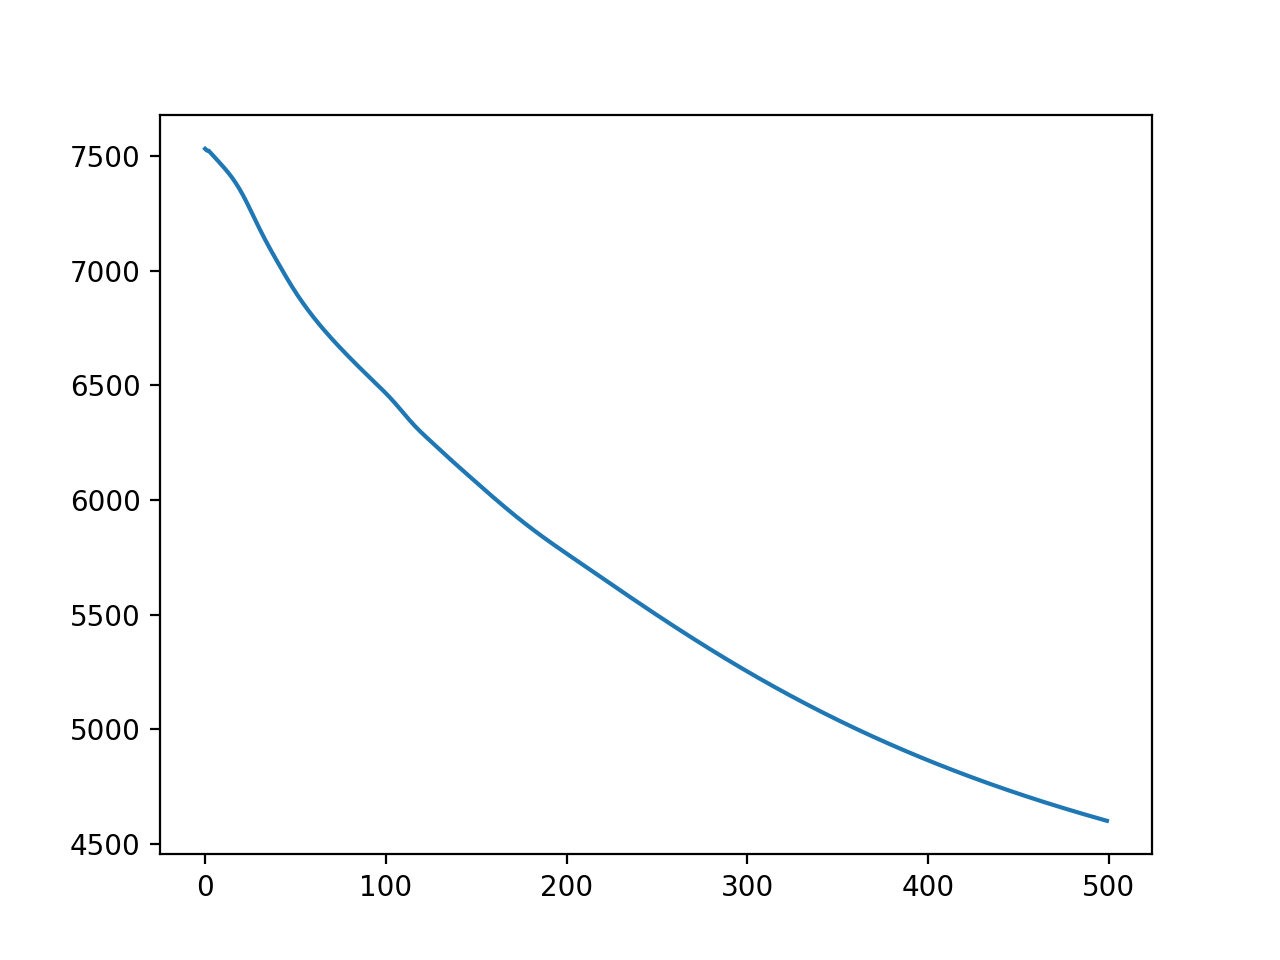

Min LL: 4600.81298828125


In [33]:
plt.clf()
%matplotlib notebook
model_dist = Watson
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.01)

epoch_likelihood = train_mixture(model, data=X, optimizer=Adam_optimizer, num_epoch=500)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {epoch_likelihood[-1]}')

## Test fitting

In [60]:
param = get_param(model)

pi
tensor([0.0126, 0.2522, 0.7351])
------------------------------
mix_comp_0
{'mu': tensor([0.2492, 0.6730, 0.6964]), 'kappa': tensor([2.9646])}
------------------------------
mix_comp_1
{'mu': tensor([0.2092, 0.6782, 0.7045]), 'kappa': tensor([4.0145])}
------------------------------
mix_comp_2
{'mu': tensor([0.9996, 0.0203, 0.0200]), 'kappa': tensor([5.5421])}
------------------------------


#### Simulate based on learned parameters

In [35]:
## Synthectic as np array
synX, syn_cluster_id = np.array(X), np.array(cluster_id)

In [61]:
model(torch.rand(5,3))

tensor(-16.1281, grad_fn=<SumBackward0>)

### Plotting setting config

# Plot of Synthetic vs Learned Mixture Parameters

<IPython.core.display.Javascript object>


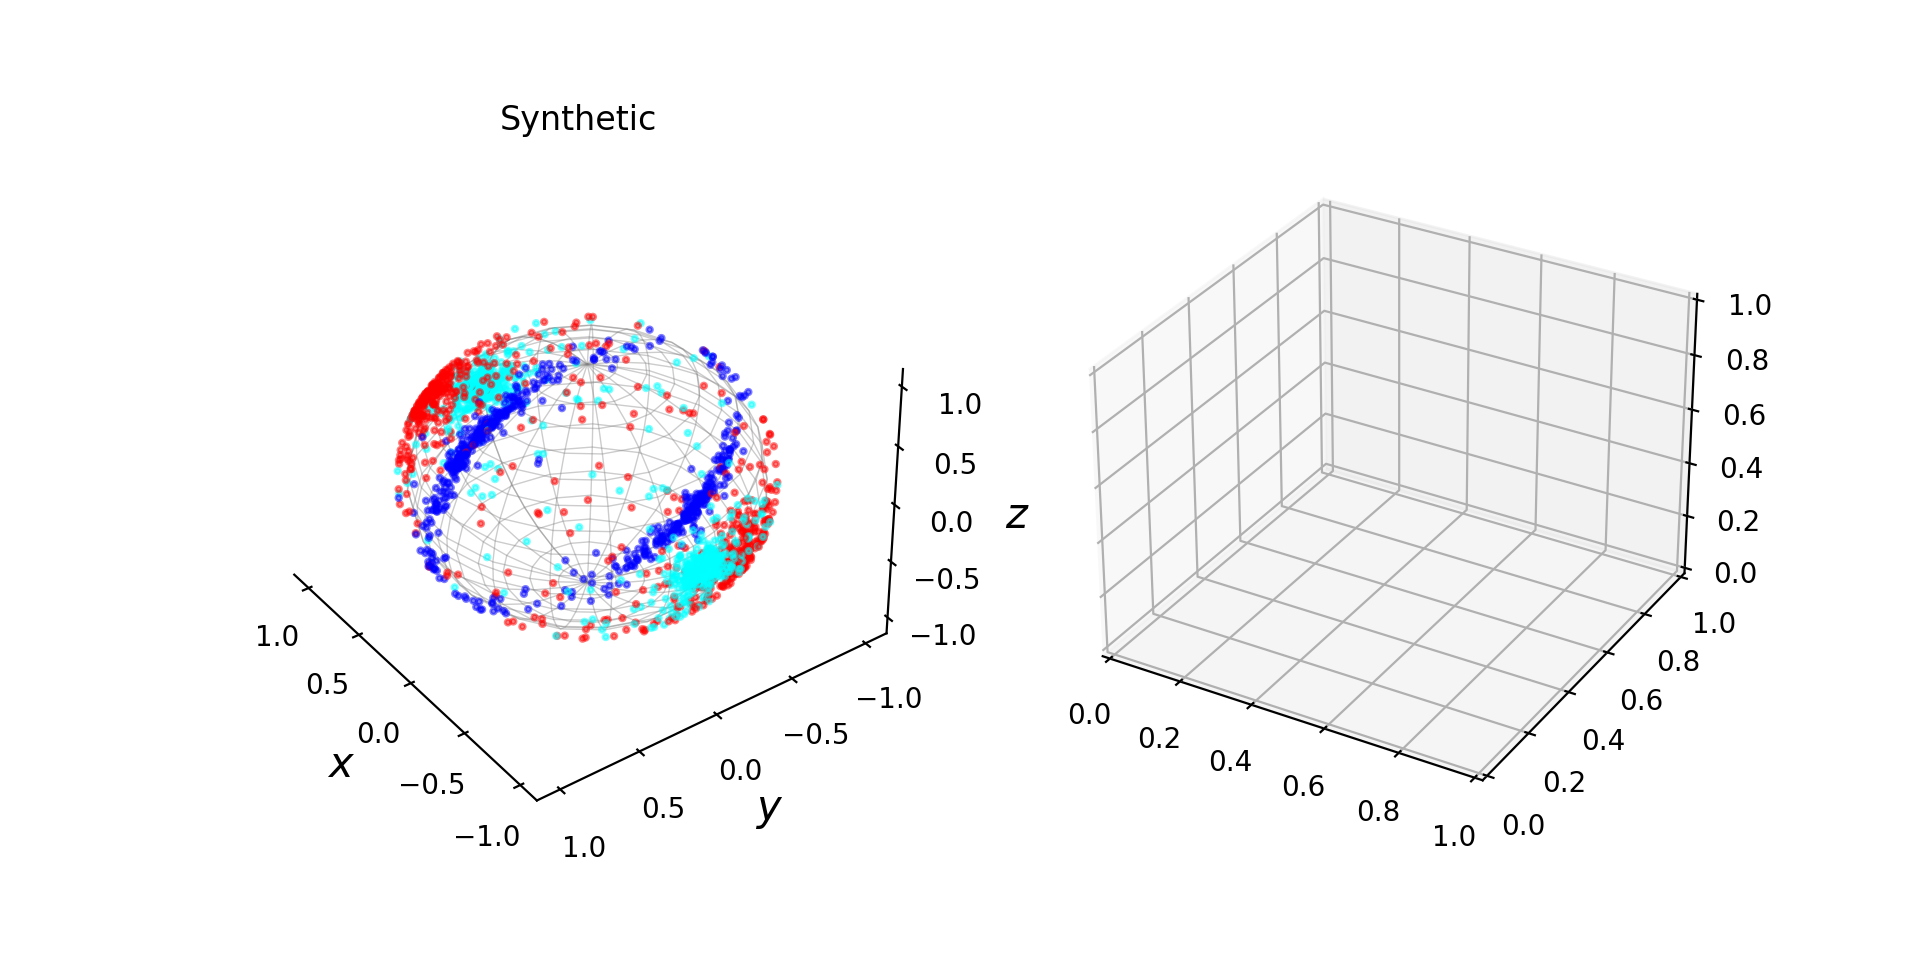

NameError: name 'Learn_cluster_id' is not defined

In [53]:
if model_dist == ACG:
    learned_sigma = torch.stack([param[f'mix_comp_{idx}'] for idx in range(model.K)])
    learned_pi = param['pi']
    LearnX, Learn_cluster_id = synthetic3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

    # Synthetic
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Synthetic')
    #Background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = .95 * np.outer(np.cos(u), np.sin(v))
    y = .95 * np.outer(np.sin(u), np.sin(v))
    z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
    ax.view_init(30, 135)

    # Learned
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    label_color = [id_2_color[id] for id in Learn_cluster_id]
    ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Generated - Learned parameters')
    ax.view_init(30, 135)
    plt.show()




elif model_dist == Watson:
    Watson_comps = [param[f'mix_comp_{idx}'] for idx in range(model.K)]
    learned_pi = param['pi']
    
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

    # Synthetic
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Synthetic')
    #Background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = .95 * np.outer(np.cos(u), np.sin(v))
    y = .95 * np.outer(np.sin(u), np.sin(v))
    z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
    ax.view_init(30, 135)

    # Learned
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    label_color = [id_2_color[id] for id in Learn_cluster_id]
    ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Generated - Learned parameters')
    ax.view_init(30, 135)
    plt.show()
    